In [10]:
from micrograd.engine import Value 

a = Value(-4.0)
b = Value(2.0)# Stores gradient of variable 
# Demomonstrate supportd operations for Value  


# # Note that without enstantiating the variable "C" in micrograd, it will know that C has "a" & "b" as child nodes 
    # Maintains pointers to variables
c = a+b 
d= a * b + b ** 3 
c += c + 1 
c += 1 + c + ( -a)

d += d * 2 + (b+ a).relu() # squashes at 0 
d += 3 * d + (b-a).relu()

e = c-d 
f = e**2
g = f/2.0 
g += 10.0/f 
print(f'{g.data:.4f}') # Forward pass evaluates value of G: 24.7041
g.backward() # initializes backpropogation at Node g -> Recursively applies chain rule (calculas) -> derivative of G w/ respect to all nodes (e,d,c) & inputs( a,b )  

print(f'{a.grad:.4f}') # --> 138.8338, dg/da

print(f'{b.grad:.4f}') # --> dg/db

24.7041
138.8338
645.5773


In [7]:
import math
import numpy as np 

import matplotlib.pyplot as plt 

%matplotlib inline 


In [19]:
xs = np.arange(-5,5 , 0.25 )
ys = f(xs)


array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

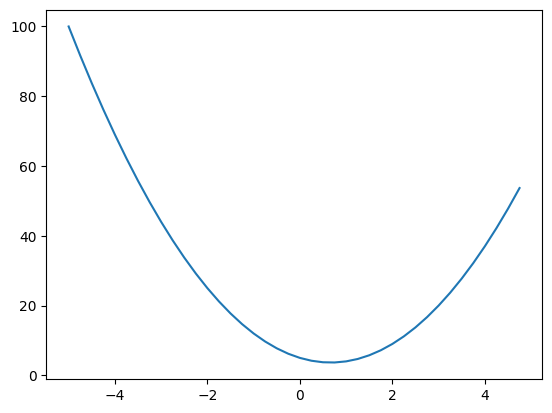

In [20]:
plt.plot(xs, ys)

In [26]:
h = 0.001 
x = 3.0 

(f(x+h)-f(x))/(h)

14.00300000000243

In [53]:
Value(5) + 5
Value(6) * 1

Value(data=6)

In [125]:
class Value:

    def __init__(self,data, _children = (), _op = '', label =''):
        self.data = data
        self._prev = set(_children)
        self.grad = 0.0
        self._backward = lambda : None
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward(): 
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out 
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) -1) / (math.exp(2*n) + 1 )
        out =  Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - out.data**2) * out.grad
        out._backward = _backward 
        return out 
    
    def __mul__(self, other):
        other = Value(other) if isinstance(other, (int, float)) else other
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad 
        out._backward = _backward
        return out 
    def __pow__ (self, other):
        assert isinstance(other, (int, float)) 
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += out.grad * self.data * other ** (other-1) 
        
        out._backward = _backward
        return out 
    
    def __truediv__(self, other): #self / other
        return self * other**-1
    def __neg__(self): # -self
        return self * -1 
    def  __sub__(self, other): #self - other
        return self  + (-other) 
    def __radd__(self, other): # other + self
        return self + other
    
    def __rmul__(self,other): #inverses * Value() 
        return self * other
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward 
        return out 

    def backward(self):
        self.grad = 1 

        # get topological order, as back prop starts from lead node to child 
        topo = []
        visited = set() 
        def build_topo(v):
            if v not in visited: 
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        for node in reversed(topo): node._backward()

In [50]:
from graphviz import Digraph
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s |data %.4f  | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

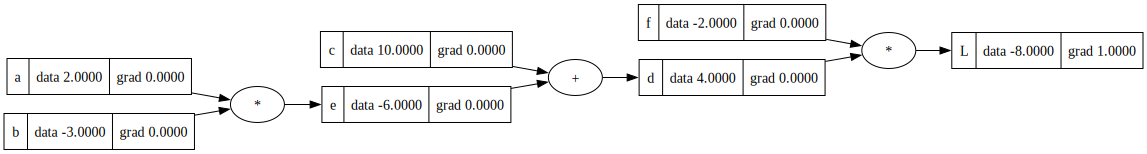

In [123]:
draw_dot(L)

In [5]:
x1= Value(2.0, label = 'x1')
x2= Value(0.0, label = 'x2')

# Weighs
w1= Value(-3.0, label = 'w1')
w2= Value(1.0, label = 'w2')
# Bias 
b= Value(6.8813735870195432, label = 'b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 *w2 ; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label= 'o'; 





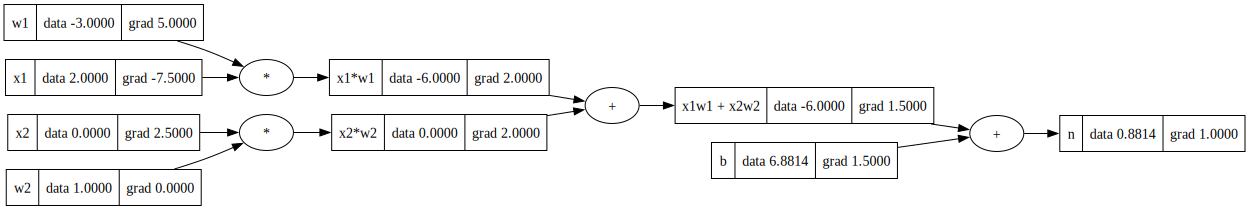

In [7]:
n.backward()
draw_dot(n)

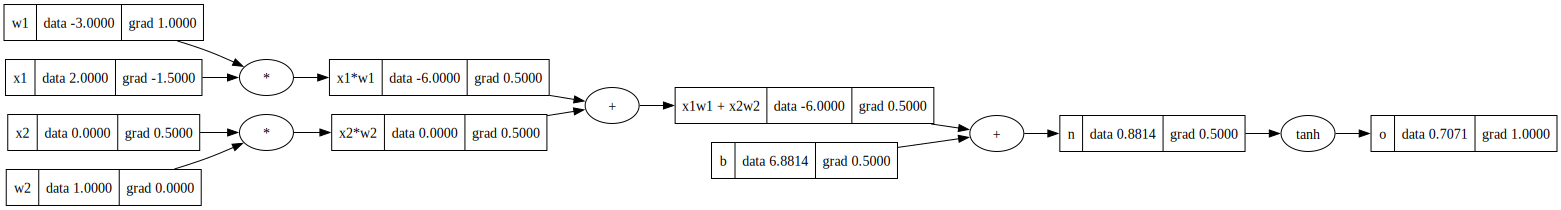

In [6]:
o.backward()
draw_dot(o)

In [38]:
a = Value(5, label = 'a')
b = Value(7, label = 'b')
c = Value(-1, label = 'c')
d = Value(12, label = 'd')

L = a + b ; L.label = "L"
J = a * c; J.label = 'J'
K = b* d; K.label = 'K'
G = a * b; G.label = 'G'

x = L + G ; x.label = 'x'
y = J * K; y.label = 'y'
o = x * y ; o.label ='o'
z = o.tanh(); z.label ='z'


In [47]:
z.grad = 1 

# get topological order, as back prop starts from lead node to child 
topo = []
visited = set() 
def build_topo(v):
    if v not in visited: 
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(z)
print(topo)
for node in reversed(topo): node._backward()
for node in topo: print(node)

[Value(data=5), Value(data=7), Value(data=35), Value(data=12), Value(data=47), Value(data=-1), Value(data=-5), Value(data=12), Value(data=84), Value(data=-420), Value(data=-19740), Value(data=-1.0)]
Value(data=5)
Value(data=7)
Value(data=35)
Value(data=12)
Value(data=47)
Value(data=-1)
Value(data=-5)
Value(data=12)
Value(data=84)
Value(data=-420)
Value(data=-19740)
Value(data=-1.0)


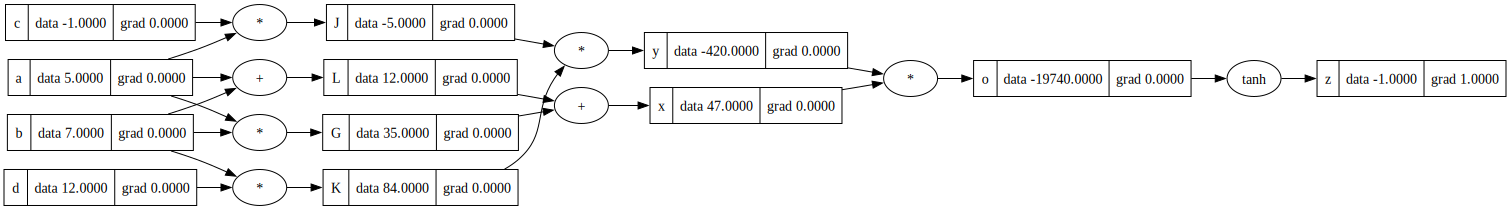

In [39]:
dz.backward()
draw_dot(z)

In [74]:
x1= Value(2.0, label = 'x1')
x2= Value(0.0, label = 'x2')

# Weighs
w1= Value(-3.0, label = 'w1')
w2= Value(1.0, label = 'w2')
# Bias 
b= Value(6.8813735870195432, label = 'b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 *w2 ; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'
# --------
e = (2*n).exp()

o = (e - 1 )/ (e+1 )
# # #---------
# print(o.data)
o.backward()

In [2]:
import torch 


In [4]:

# Pytorch by default casts to float32, so need to cast to double (python default)
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True 
x2 = torch.Tensor([0.0]).double()   ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()  ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()   ; w2.requires_grad = True 
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True 
n = x1 * w1 + x2 * w2 + b 
o = torch.tanh(n)

print(o.data.item()) 
o.backward()

print('---')
print('x2', x2.grad.item()) # need to call .item(),  or .grad will take tensor of one element, and only returns element 
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [9]:
import random

In [6]:
torch.Tensor([2.0]).double()

tensor([2.], dtype=torch.float64)

In [240]:
class Neuron:

    def __init__(self, nin): # number of inputs to a neuron from a dendrite
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self,x):

        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
# list of neurons 
class Layer: 
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x ):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)  == 1 else outs 
    def parameters(self):
        return [ p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [ Layer(sz[i], sz[i +1 ]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [ p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0]
n = Neuron(2)
n(x) # Returns value of call

Value(data=0.6901924945655376)

In [189]:
#Creating layer of neurons 
x = [2.0, 3.0]
n = Layer(2, 3) # 2 dimensional neurons, 3 neurons
n(x) # Returns value of call

[Value(data=-0.800957517608407),
 Value(data=-0.9969844413450634),
 Value(data=-0.9697784449461927)]

In [241]:
x = [2.0, 3.0, -1.0]
n = MLP( 3, [4,4,1])
n(x)

Value(data=-0.16615112142360225)

In [192]:
n.parameters() # prints weights and biases 

[Value(data=-0.8949672523842762),
 Value(data=0.3621619858851082),
 Value(data=0.434721781049789),
 Value(data=0.4498879316647666),
 Value(data=-0.9541306465028978),
 Value(data=-0.6184866803616373),
 Value(data=0.8039722700380834),
 Value(data=-0.9718927871824814),
 Value(data=0.46765593114029747),
 Value(data=0.5728950891947877),
 Value(data=0.9714005750699006),
 Value(data=0.7393432835277254),
 Value(data=0.4996491953523241),
 Value(data=-0.20087327576505865),
 Value(data=0.3239208456532001),
 Value(data=0.5550091790395373),
 Value(data=0.6622429130373859),
 Value(data=0.6688971936545169),
 Value(data=0.7663072164465872),
 Value(data=-0.0967765841392163),
 Value(data=-0.2650713778700797),
 Value(data=0.9237593130344652),
 Value(data=-0.46320483675742175),
 Value(data=0.05424421121831546),
 Value(data=0.9486115821468342),
 Value(data=0.7363427140166963),
 Value(data=0.7258382333436),
 Value(data=-0.5528669080591371),
 Value(data=0.6506276130294253),
 Value(data=0.9594979557346126),
 

In [238]:
# Examples
# 4 possible inputs

xs = [
    [2.0, 3.0, -1.0], # should output 1.0, as designated in ys
    [3.0, -1.0, 0.5], # -1.0
    [0.5, 1.0, 1.0], # -1.0
    [1.0, 1.0, -1.0] # 1.0
]

ys = [ 1.0, -1.0, -1.0, 1.0] # desired targets 
ypred = [ n(x) for x in xs]
ypred


[Value(data=1.0), Value(data=1.0), Value(data=1.0), Value(data=1.0)]

In [204]:
ypred = [ n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]) # mean squared error loss, ygt --> ground truth
loss

Value(data=7.853291101679629)

In [202]:
loss.backward()

In [184]:
n.layers[0].neurons[0].w[0]
n.layers[0].neurons[0].w[0].grad

53.657843963450574

In [203]:
for p in n.parameters(): # 0.01 is an arbitrary step size 
    p.data += -0.01 * p.grad # the Gradient is w/ respect to the loss
        # so you want to decrease the .data value in direction of decrasing loss 

In [261]:
# Summary of Gradient descent 

for k in range(10): # steps 

    # forward pass
    ypred = [ n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]) # mean squared error loss, ygt --> ground truth

    # Reset gradients to 0, or else it will keep adding up 
    for p in n.parameters():
        p.grad = 0.0
    #backward pass
    loss.backward()

    #update 
    for p in n.parameters():  # 0.01 is the learning rate 
        p.data += -0.001 * p.grad


    print(k, loss.data)



0 0.7418509134541746
1 0.7338821176195055
2 0.726024798738165
3 0.7182776891922606
4 0.7106395055524235
5 0.7031089508460703
6 0.6956847167035665
7 0.6883654853859505
8 0.6811499316980083
9 0.6740367247905821


In [237]:
ypred

[Value(data=1.0), Value(data=1.0), Value(data=1.0), Value(data=1.0)]